# RNN From Scratch
Nationality prediction on the names dataset, using characters as tokens. There are 18 nationalities in the dataset.

Based off of:
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

1) We download the data and process it.
2) We build an RNN from scratch
3) We train the RNN on test and demonstrate 70% accuracy after 200_000 samples.
4) We define a predict function and use it to create a confusion matrix on the whole dataset.
5) We use a confusion matrix heatplot to see how the model handled the multi class classification.
6) We look at some of the worst predictions (model was most certain about but were actually incorrect)

In [26]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import zipfile

In [27]:
# download data from: https://download.pytorch.org/tutorial/data.zip
zipfile.ZipFile('data/names.zip').extractall('')
file_list = glob.glob('data/names/*.txt')
file_list

['data/names/Vietnamese.txt',
 'data/names/Dutch.txt',
 'data/names/Korean.txt',
 'data/names/Irish.txt',
 'data/names/Scottish.txt',
 'data/names/Arabic.txt',
 'data/names/Greek.txt',
 'data/names/Russian.txt',
 'data/names/German.txt',
 'data/names/English.txt',
 'data/names/Portuguese.txt',
 'data/names/Italian.txt',
 'data/names/French.txt',
 'data/names/Czech.txt',
 'data/names/Spanish.txt',
 'data/names/Polish.txt',
 'data/names/Japanese.txt',
 'data/names/Chinese.txt']

In [79]:
import unicodedata
import string
all_letters = string.ascii_letters + " .,;'"
print('letters to be encoded:', all_letters)
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

letters to be encoded: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski


In [80]:
data = pd.DataFrame(columns=['name', 'nationality'])
for f in file_list:
    temp = pd.read_csv(f, header = None, names=['name'], sep ='|')
    temp['nationality'] = f.split('/')[2][:-4] # file name with .txt removed
    data = pd.concat([data,temp], axis=0)
# convert names to ascii
data['name'] = data['name'].map(unicodeToAscii)
class_labels = data.nationality.unique()
data

,name,nationality
0,Nguyen,Vietnamese
1,Tron,Vietnamese
2,Le,Vietnamese
3,Pham,Vietnamese
4,Huynh,Vietnamese
...,...,...
263,Zhai,Chinese
264,Zhang,Chinese
265,Zhi,Chinese
266,Zhuan,Chinese


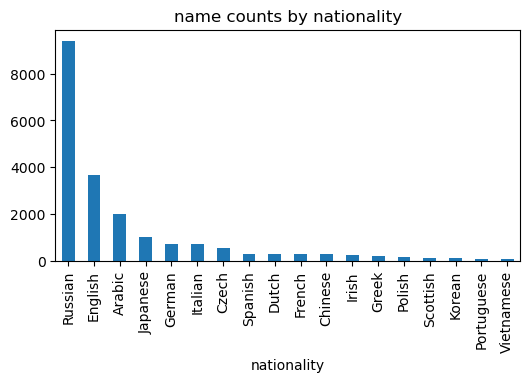

In [81]:
# plot value counts
class_counts = data['nationality'].value_counts()
class_counts.plot(kind='bar', figsize=(6,3), title='name counts by nationality')
plt.show()

In [82]:
# we can weight the classes by their inverse class size for training
class_weights = 1/(class_counts[class_labels].values)

In [83]:
# lets find the characters appearing in the dataset to confirm they look reasonable
chars_in_data = set()
for n in data['name'].values:
    chars_in_data = chars_in_data.union(list(n))
chars_in_data = list(chars_in_data)
chars_in_data = sorted(chars_in_data)
print('characters appearing in the dataset:', ''.join(chars_in_data))

characters appearing in the dataset:  ',ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [84]:
# functions to convert names to tensors
num_letters = len(all_letters)
def letter_to_ohe_tensor(letter):
    # function to convert a letter into one hot encoded vectors
    idx = torch.tensor(all_letters.find(letter))
    return F.one_hot(idx, num_letters).reshape(1,-1)

def name_to_ohe_tensor(name):
    # function to convert a name into one a tensort of ohe encoded vectors
    idxs = torch.tensor([all_letters.find(letter) for letter in name])
    return F.one_hot(idxs, num_letters)

name_to_ohe_tensor('Alex,')

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [34]:
# lets build the RNN from scratch:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        # input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # hidden to output
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) #concatenate
        hidden = self.i2h(combined) # concat feeds to hidden
        output = self.h2o(hidden) # hidden feeds to output
        output = self.softmax(output) # log probabilities (log softmax)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_categories = len(class_labels)
rnn = RNN(n_letters, n_hidden, n_categories)

# test on an input
hidden = rnn.initHidden()
ohe_letter = letter_to_ohe_tensor('a')
output, hidden = rnn(ohe_letter, hidden)
print(output.shape, hidden.shape)

torch.Size([1, 18]) torch.Size([1, 128])


In [85]:
# define a function to map a natioanlity to a tensor
nationality_to_idx = {n:idx for idx, n in enumerate(class_labels)}
def nationality_to_tensor(nationality):
    return torch.tensor(nationality_to_idx[nationality])

print(class_labels[0],':', nationality_to_tensor(class_labels[0]))
print(class_labels[1],':', nationality_to_tensor(class_labels[1]))

Vietnamese : tensor(0)
Dutch : tensor(1)


In [86]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
criterion = nn.NLLLoss(weight=torch.tensor(class_weights, dtype=torch.float32))

def train_name(name, nationality):
    X = name_to_ohe_tensor(name)
    y = nationality_to_tensor(nationality)

    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for x in X:
        output, hidden = rnn(x.reshape(1,-1), hidden)

    loss = criterion(output[0], y)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [87]:
# train model
rnn = RNN(n_letters, n_hidden, n_categories)

inputs, labels = data.name.values, data.nationality.values
iterations = 200_000
verbosity = int(iterations/10)

n_correct = 0
running_loss = 0
for i in range(iterations):
    idx = np.random.choice(len(inputs))
    input, label = inputs[idx], labels[idx]
    output, loss = train_name(input, label)
    _, pred_label = torch.max(output, 1)

    n_correct += (pred_label.item() == nationality_to_idx[label])
    running_loss += loss
    if (i+1) % verbosity == 0:
        accuracy = n_correct/verbosity
        running_loss = running_loss/verbosity
        print(f'iter {i+1}, loss {running_loss:.2f}, accuracy {accuracy:.2f}')
        n_correct, running_loss = 0, 0


iter 20000, loss 1.33, accuracy 0.61
iter 40000, loss 1.01, accuracy 0.70
iter 60000, loss 0.94, accuracy 0.72
iter 80000, loss 0.89, accuracy 0.73
iter 100000, loss 0.86, accuracy 0.74
iter 120000, loss 0.86, accuracy 0.73
iter 140000, loss 0.83, accuracy 0.74
iter 160000, loss 0.82, accuracy 0.74
iter 180000, loss 0.82, accuracy 0.74
iter 200000, loss 0.83, accuracy 0.74


In [88]:
# lets create a predict nationality function for a name
def predict_nationality(name, model):
    model.eval()
    X = name_to_ohe_tensor(name)
    hidden = rnn.initHidden()
    with torch.no_grad():
        for x in X:
            output, hidden = model(x.reshape(1,-1), hidden)
    log_prob, idx = torch.max(output, 1)
    return np.exp(log_prob.item()), class_labels[idx.item()]

for name in ['George', 'Zhang', 'Vladislav', 'Phu', 'Sayed', 'Reinhardt']:
    prob, label = predict_nationality(name, rnn)
    print(f'{name} is {label} with probability {prob:.2f}')

George is English with probability 0.32
Zhang is Chinese with probability 0.78
Vladislav is Russian with probability 1.00
Phu is Chinese with probability 0.50
Sayed is Arabic with probability 0.46
Reinhardt is Russian with probability 0.37


In [89]:
# lets add a new column to the dataframe
data['prob_pred'] = [predict_nationality(name, model = rnn) for name in inputs]

In [90]:
data['prob'] = [x[0] for x in data['prob_pred']]
data['pred'] = [x[1] for x in data['prob_pred']]

Text(0.5, 1.0, 'Confusion Matrix')

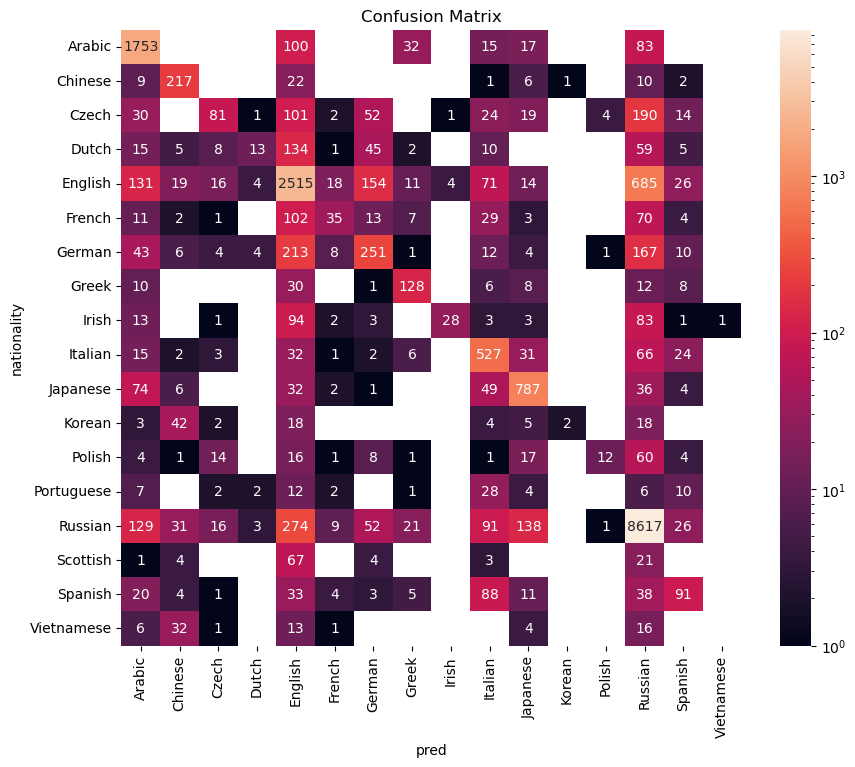

In [91]:
import seaborn as sns
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,8))
sns.heatmap(pd.crosstab(data.nationality, data.pred).round(3), 
            annot = True, fmt='g', norm =LogNorm()).set_title('Confusion Matrix')

In [92]:
#lets view the worst predictions, the model seems to think a lot of things are russian, especially check names (which make sense)
data_incorrect = data[data.pred != data.nationality]
# sort by descending probabilitys (pandas.sort_values was struggling here)
data_incorrect.iloc[(-data_incorrect.prob).argsort(), :].drop(['prob_pred'], axis=1).head(20)

,name,nationality,prob,pred
19,Blazejovsky,Czech,0.999874,Russian
25,Bohunovsky,Czech,0.999582,Russian
454,Svejkovsky,Czech,0.999411,Russian
100,Georgijev,Czech,0.999174,Russian
30,Borovsky,Czech,0.998541,Russian
224,Krhovsky,Czech,0.996662,Russian
378,Sankovsky,Czech,0.996610,Russian
620,Straub,German,0.995968,Arabic
39,Abaza,Russian,0.995780,Arabic
28,Bokhoven,Dutch,0.993904,Russian
